In [122]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### 为movieId建立新的索引

In [123]:
data_raw = pd.read_csv('ratings.csv')
movie2index = {} # {movieId: index}
index2movie = {} # {index: movieId}
for index, movieId in enumerate(data_raw['movieId'].unique()):
    movie2index[movieId] = index
    index2movie[index] = movieId

### 数据预处理

In [124]:
def data_preprocess(data_path:str)->pd.DataFrame:
    """
    数据预处理
    :param data_path: 数据路径
    :return: 处理后的数据
    """
    data_raw = pd.read_csv(data_path)   # 读取数据
    data_raw = data_raw.iloc[:, :3] # 去掉时间戳
    data_raw = data_raw.sample(frac=1, random_state=42) # 打乱数据
    return data_raw

In [125]:
data_raw = data_preprocess("ratings.csv")

In [126]:
data_raw

,userId,movieId,rating
67037,432,77866,4.5
42175,288,474,3.0
93850,599,4351,3.0
6187,42,2987,4.0
12229,75,1610,4.0
...,...,...,...
6265,42,4005,4.0
54886,364,141,4.0
76820,480,6867,4.0
860,6,981,3.0


### k折交叉验证,并转化为numpy数组

In [127]:
def get_data_matrix(data:list[list], user_num:int, movie_num:int)->np.ndarray:
    """
    获取数据矩阵
    :param data: 数据
    :param user_num: 用户数量
    :param movie_num: 电影数量
    """
    
    data_matrix = np.zeros((user_num, movie_num))
    for record in data:
        user = int(record[0])   # 用户名
        movieId = int(record[1])  # 电影
        movie = movie2index[movieId] 
        rating = record[2]      # 评分
        data_matrix[user-1, movie] = rating
    return data_matrix

In [128]:
def k_folds(data:pd.DataFrame, k=10) -> tuple[np.ndarray, np.ndarray]:
    """
    k折交叉验证
    :param data: 数据
    :param k: 折数
    :return: 训练集和验证集
    """
    user_num, movie_num = data_raw['userId'].max(), data_raw['movieId'].nunique()
    data = data.values.tolist()
    each_fold_size = len(data) // k  # 每折的长度
    for i in range(k):
        # 根据循环次数划分不同的训练集和测试集
        if i == k - 1:
            valid = data[i * each_fold_size:]
            train = data[:i * each_fold_size]
        elif i == 0:
            valid = data[: (i + 1) * each_fold_size]
            train = data[(i + 1) * each_fold_size:]
        else:
            valid = data[i * each_fold_size: (i + 1) * each_fold_size]
            train = data[: i * each_fold_size] + data[(i + 1) * each_fold_size :]

        # print(f"第{i+1}折: 训练集长度为{len(train)}, 验证集长度为{len(valid)}")
        yield get_data_matrix(train,user_num,movie_num), get_data_matrix(valid,user_num,movie_num)

In [129]:
# print(" train_len   valid_len")
for train_matrix, val_matrix in k_folds(data_raw):
    print(train_matrix.shape, val_matrix.shape)


(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)
(610, 9724) (610, 9724)


### 计算皮尔逊系数
![Pearson](PCC.png)

In [130]:
def Pearson(rating_a, rating_b):
    """
    计算皮尔逊相关系数
    :param rating_a: 用户a的评分
    :param rating_b: 用户b的评分
    :return: 皮尔逊相关系数
    """
    temp_a = rating_a - np.mean(rating_a)
    temp_b = rating_b - np.mean(rating_b)
    numerator = np.sum(temp_a * temp_b)
    denominator = np.sqrt(np.sum(temp_a ** 2)) * np.sqrt(np.sum(temp_b ** 2))
    return numerator / denominator if denominator != 0 else np.nan

### Cosine相似度
![Cosine](Cosine.png)

In [131]:
def Cosine(rating_a, rating_b):
    """
    计算余弦相似度
    :param rating_a: 用户a的评分
    :param rating_b: 用户b的评分
    :return: 余弦相似度
    """
    numerator = np.sum(rating_a * rating_b)
    denominator = np.sqrt(np.sum(rating_a ** 2)) * np.sqrt(np.sum(rating_b ** 2))
    return numerator / denominator if denominator != 0 else np.nan

In [132]:
from typing import Callable
def calculate_similarity(train_matrix:np.ndarray, sim_func:Callable=Pearson)->np.ndarray:
    """
    计算皮尔逊相关系数
    :param train_matrix: 训练集矩阵
    :return: 皮尔逊相关系数矩阵
    """
    n_users, n_movies = train_matrix.shape # 用户数和电影数
    sim_matrix = np.full((n_users, n_users), np.nan) # 初始化皮尔逊相关系数矩阵

    # 获取每个用户看过的电影
    seen_movies = {}
    for user in range(n_users):
        seen_movies[user] = np.flatnonzero(train_matrix[user])

    for user_a in range(n_users):
        for user_b in range(n_users):
            if user_a <= user_b:    # 只计算上三角
                continue
            # 计算两个用户评价过的物品交集
            intersection_movies = np.intersect1d(seen_movies[user_a], seen_movies[user_b], assume_unique=True)

            # 如果交集为空，跳过
            if len(intersection_movies) == 0:   
                continue

            rating_a = train_matrix[user_a][intersection_movies]    # 用户a的交集电影评分
            rating_b = train_matrix[user_b][intersection_movies]    # 用户b的交集电影评分
            
            # 计算相似度
            sim_matrix[user_a][user_b] = sim_matrix[user_b][user_a] = sim_func(rating_a, rating_b)

    return sim_matrix


In [133]:
for train_matrix, val_matrix in k_folds(data_raw):
    train_matrix =train_matrix
    val_matrix = val_matrix
    break

In [134]:
pcc_matrix = calculate_similarity(train_matrix,sim_func=Pearson)

In [135]:
pcc_matrix[0]

array([            nan,             nan,  8.57492926e-02,  1.62507744e-01,
        1.85030142e-01, -2.73840122e-01, -7.24656707e-02,  4.50287265e-01,
        9.04534034e-01, -3.56348323e-01, -9.62911108e-02,             nan,
        8.70388280e-01,  2.01801838e-01,  2.74861709e-01,  8.88395473e-02,
        3.19529969e-02,  2.13184313e-01,  2.87154742e-01,  3.62652929e-01,
        3.24116186e-01, -5.45544726e-01, -5.59016994e-01,  2.33628359e-01,
       -2.50000000e-01,  1.41421356e-01,  1.38539617e-01, -2.65950148e-02,
       -1.76313813e-01, -1.66666667e-01, -2.25374703e-17,  2.59619727e-01,
        3.10885002e-02,  6.45927987e-02,  0.00000000e+00,  4.38208373e-01,
       -6.32653061e-01,  1.71829629e-01, -1.47624184e-01, -3.54005216e-01,
       -1.90207227e-01,  1.94219617e-01,  1.71377655e-01,  6.29541206e-01,
        2.31241008e-01,  4.16666667e-02,  5.62401588e-01, -1.92450090e-01,
        7.07106781e-01,  2.82884282e-02,  1.94060681e-01, -5.12989176e-01,
                   nan, -

### 获取潜在相邻用户

In [136]:
def sort_neighbor(pcc_matrix:np.ndarray)->dict:
    """
    获取潜在相邻用户
    :param pcc_matrix: 皮尔逊相关系数矩阵
    :return: 相邻用户矩阵
    """
    n_users = pcc_matrix.shape[0]
    neighbor_dict = {}
    for user in range(n_users):
        sorted_arr = np.argsort(pcc_matrix[user])[::-1] # 降序排列
        sorted_arr = sorted_arr[np.isnan(pcc_matrix[user][sorted_arr]) == False]    # 去掉nan
        neighbor_dict[user] = sorted_arr
    return neighbor_dict

In [137]:
neighbors_dict = sort_neighbor(pcc_matrix)

In [138]:
neighbors_dict[0]

array([145, 397, 549, 486, 472, 105, 597, 138, 594, 510,   8, 365,  89,
        12, 534, 480, 498, 567, 296, 113, 529, 206, 236, 161, 162,  48,
       444, 475, 393, 487, 208, 429, 542, 350, 123,  43, 172,  64, 247,
       177, 175, 573,  71, 434,  98, 112, 302, 420, 400, 217, 318, 504,
       595, 343, 466, 299,  46, 111, 339, 200, 506, 214, 262, 368, 574,
       209, 497, 184,  54, 132, 301, 167, 441, 284, 134, 235, 125, 374,
       493, 476, 525, 205, 478, 430, 171, 300, 322, 450, 448, 347, 596,
         7, 349,  35, 275,  74, 245, 144, 282, 483, 413, 520, 269, 166,
       388, 213, 307, 188, 522,  68, 511, 592,  61, 417, 225, 571, 337,
       169, 119, 137, 326, 512, 315, 215, 135, 551, 539, 159,  75, 198,
        56, 211, 118,  19, 554, 463, 378, 121, 241, 313, 535, 455, 509,
       447, 433, 286, 607, 311, 191, 170, 265, 599, 503,  20,  99, 248,
       384, 267, 243, 154, 199, 589, 306, 576, 446,  18, 523, 482, 164,
       411,  88, 457,  14, 494, 367, 309, 502, 218,  92, 507,  3

In [139]:
pcc_matrix[0][neighbors_dict[0]]

array([ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        1.00000000e+00,  1.00000000e+00,  1.00000000e+00,  9.17662935e-01,
        9.04534034e-01,  9.04534034e-01,  9.04534034e-01,  9.04534034e-01,
        8.96421457e-01,  8.70388280e-01,  8.68599036e-01,  8.66025404e-01,
        8.02955069e-01,  8.01783726e-01,  7.91922945e-01,  7.59256602e-01,
        7.55928946e-01,  7.30296743e-01,  7.26815568e-01,  7.08333333e-01,
        7.07106781e-01,  7.07106781e-01,  7.00472797e-01,  6.93375245e-01,
        6.81919047e-01,  6.73900752e-01,  6.66666667e-01,  6.54653671e-01,
        6.45497224e-01,  6.32455532e-01,  6.30714997e-01,  6.29541206e-01,
        6.17213400e-01,  6.12372436e-01,  6.12372436e-01,  6.04056767e-01,
        5.98799461e-01,  5.97614305e-01,  5.94467772e-01,  5.89767825e-01,
        5.83450035e-01,  5.80947502e-01,  5.79954809e-01,  5.78351745e-01,
        5.77350269e-01,  5.77350269e-01,  5.77350269e-01,  5.77350269e-01,
        5.76741477e-01,  

### 计算训练集中每个用户的平均分

In [140]:
def avg(train_matrix:np.ndarray)->np.ndarray:
    """
    计算每个用户的平均评分
    :param train_matrix: 训练集矩阵
    :return: 每个用户的平均评分
    """
    n_users, n_movies = train_matrix.shape
    avg_array = np.full(n_users, 3.5)   # 初始化为3.5
    for user in range(n_users):
        avg_array[user] = np.mean(train_matrix[user][train_matrix[user] != 0])
    return avg_array

In [141]:
avg_array = avg(train_matrix)
avg_array[:10]

array([4.33333333, 3.92592593, 2.52941176, 3.51269036, 3.62790698,
       3.49462366, 3.25954198, 3.68421053, 3.28888889, 3.2375    ])

### 预测评分
![predict](predict.png)

In [142]:
def predict(train_matrix:np.ndarray, valid_matrix:np.ndarray, pcc_matrix:np.ndarray, neighbors_dict:dict, avg_array:np.ndarray, neighbor_num:int)->np.ndarray:
    """
    预测用户对电影的评分
    :param train_matrix: 训练集矩阵
    :param valid_matrix: 验证集矩阵
    :param pcc_matrix: 皮尔逊相关系数矩阵
    :param neighbors_dict: 相邻用户字典
    :param avg_array: 每个用户的平均评分
    :param neighbor_num: 相邻用户的个数
    :return: 预测矩阵
    """
    pred_matrix = np.zeros(valid_matrix.shape)
    # neighbor_used = [] # 记录预测每部电影时使用的相邻用户的个数
    
    for user in range(pred_matrix.shape[0]):
        to_predict_movies = np.flatnonzero(valid_matrix[user])  # 需要预测的电影
        neighbors = neighbors_dict[user]    # 潜在相邻用户
        for movie in to_predict_movies: # 遍历每个需要预测的电影
            numerator = 0
            denominator = 0
            neighbors_now = 0 # 记录当前使用的相邻用户的个数
            for neighbor in neighbors:  # 遍历每个潜在相邻用户
                if train_matrix[neighbor, movie] == 0:  # 如果相邻用户没有评价过该电影，则跳过
                    continue
                
                neighbors_now += 1
                numerator += pcc_matrix[user, neighbor] * (train_matrix[neighbor, movie] - avg_array[neighbor])
                denominator += abs(pcc_matrix[user, neighbor])

                if neighbors_now >= neighbor_num:  # 如果已使用的邻居数量已达到要求，则跳出循环
                    break
            # neighbor_used.append(neighbors_now)
            pred_matrix[user, movie] = avg_array[user] + numerator / denominator if denominator != 0 else avg_array[user]
    # print(f"使用的邻居数量：{np.mean(neighbor_used)}")  # 平均使用的相邻用户的个数
    return pred_matrix

In [143]:
predict_matrix = predict(train_matrix, val_matrix, pcc_matrix, neighbors_dict, avg_array, neighbor_num=100)

In [144]:
predict_matrix[0][predict_matrix[0] != 0]

array([3.68054047, 4.4245708 , 4.50306225, 5.01889796, 4.6885787 ,
       4.49870266, 4.15257603, 4.47949557, 4.56827194, 4.82101365,
       4.32602564, 4.71892038, 4.42683205, 4.09094199, 4.6927267 ,
       4.01194207, 3.90584459, 4.66340572, 4.39036123, 4.44288729,
       4.57083333, 4.90759666, 4.76610595, 4.7228964 , 4.85559464])

In [145]:
def MAE(predict_matrix:np.ndarray, valid_matrix:np.ndarray)->float:
    """
    计算MAE
    :param predict_matrix: 预测矩阵
    :param valid_matrix: 验证集矩阵
    :return: MAE
    """
    # 找到非零元素的索引
    nonzero_indices = np.nonzero(valid_matrix)
    # 计算MAE
    mae = np.mean(np.abs(valid_matrix[nonzero_indices] - predict_matrix[nonzero_indices]))
    return mae

In [146]:
MAE(predict_matrix, val_matrix)

0.6842923417407196

# 完整流程

In [147]:
def user_based_CF(data_path:str, neighbor_num:int, fold_num:int, sim_func:Callable=Pearson, log:bool=True)->float:
    """
    基于用户的协同过滤
    :param data_path: 数据路径
    :param neighbor_num: 相邻用户的个数
    :param fold_num: 折数
    :param log: 是否打印日志
    :return: MAE
    """

    data_raw = data_preprocess(data_path)
    
    mae_list = []
    for i, (train_matrix, val_matrix) in enumerate(k_folds(data_raw, k=fold_num)):
        # 计算相似度
        pcc_matrix = calculate_similarity(train_matrix, sim_func=sim_func)
        # 对相似度字典进行排序
        neighbors_dict = sort_neighbor(pcc_matrix)
        # 计算每个用户的平均评分
        avg_array = avg(train_matrix)
        # 预测
        predict_matrix = predict(train_matrix, val_matrix, pcc_matrix, neighbors_dict, avg_array, neighbor_num=neighbor_num)
        # 计算MAE
        mae = MAE(predict_matrix, val_matrix)
        mae_list.append(mae)
        if log:
            print(f"第{i+1}折  MAE: {mae}")
    return np.mean(mae_list)

In [148]:
user_based_CF("ratings.csv", neighbor_num=100, fold_num=10)

第1折  MAE: 0.6842923417407196
第2折  MAE: 0.6637121391798777
第3折  MAE: 0.665664591829711
第4折  MAE: 0.6705688108746808
第5折  MAE: 0.6756491821718102
第6折  MAE: 0.659576863131206
第7折  MAE: 0.6737824914488775
第8折  MAE: 0.6693610353975811
第9折  MAE: 0.6714952698384485
第10折  MAE: 0.6812026259904859


0.6715305351603399

In [149]:
import time
neighbor_nums = [i for i in range(1,11)] + [i for i in range(11, 32, 2)] + [i for i in range(35, 201, 5)]
mae_list = []
start_time = time.time()
for neighbor_num in neighbor_nums:
    mae = user_based_CF("ratings.csv", fold_num=5, neighbor_num=neighbor_num, sim_func=Pearson, log=False)
    mae_list.append(mae)
    print(f"neighbor: {neighbor_num}   MAE: {mae}   time: {time.time() - start_time}")

neighbor: 1   MAE: 0.9075378665596439   time: 31.784491777420044
neighbor: 2   MAE: 0.7966726203839877   time: 64.27387404441833
neighbor: 3   MAE: 0.7525168741557946   time: 97.34932374954224
neighbor: 4   MAE: 0.7305344528632048   time: 130.9102075099945
neighbor: 5   MAE: 0.7172275400530204   time: 165.06298995018005
neighbor: 6   MAE: 0.7079659454048792   time: 199.74434542655945
neighbor: 7   MAE: 0.7016432654377034   time: 234.7432725429535
neighbor: 8   MAE: 0.6969076697928652   time: 270.08434557914734
neighbor: 9   MAE: 0.6934105926036805   time: 305.87437868118286
neighbor: 10   MAE: 0.6907115204650521   time: 341.8834903240204
neighbor: 11   MAE: 0.688866417938914   time: 378.4273111820221
neighbor: 13   MAE: 0.6857756014940501   time: 415.48789286613464
neighbor: 15   MAE: 0.683645214881931   time: 453.096816778183
neighbor: 17   MAE: 0.6821201409417234   time: 490.91009402275085
neighbor: 19   MAE: 0.6811594685980085   time: 529.1978108882904
neighbor: 21   MAE: 0.68026966

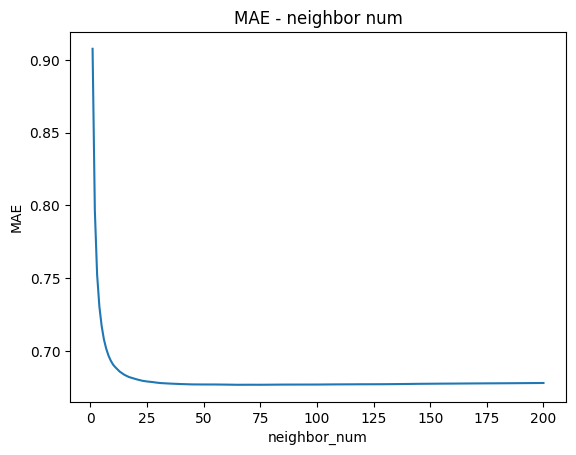

In [150]:
plt.plot(neighbor_nums, mae_list)
plt.xlabel("neighbor_num")
plt.ylabel("MAE")
plt.title("MAE - neighbor num")
plt.show()